# 1 - Exploration <a class="anchor" id="top"></a>

* [Introduction](#intro)
* [Setup](#setup)
* [Loading the data](#load-data)
* [Exploratory visualizations](#viz)

## Introduction <a class="anchor" id="intro"></a>
In this notebook, we will explore the output the data pipeline.
The resulting data set consists of flight features and statistics spanning several years, where each row represents a flight.
Further, as the ETL job joins relevant weather data to each flight, we have available to us temperature and precipitation data.

A note before continuing. 
This project is concerned with predicting the delay time for *upcoming* flights.
With that, we will focus on the relationships between variables that are either known before departure, 
or variables for which reliable forecasts exists (namely weather data).
We will examine how these variables are related to the realized delay times as well as to each other.

## Setup <a class="anchor" id="setup"></a>
First, we must import relevant Spark modules as well as libraries for statistical analysis and visualizations.
Note that will also start the Spark application that creates the `SparkSession` and sets it to the `spark` variable.

In [ ]:
%%cleanup -f

In [1]:
import pyspark
import pyspark.ml as ml
import pyspark.sql as sql
import pyspark.sql.types as types
import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1642795368239_0002,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading the data <a class="anchor" id="load-data"></a>

Now, we load the airline data from S3.
To do this, we must first get the bucket name where the data is stored.
This variable is stored on the local Sagemaker notebook instance during the `DevEnvironment` stack creation 
and must be explicitly passed to the Spark cluster.

In [2]:
%%local
import json
with open("/home/ec2-user/.aiml-bb/stack-data.json", "r") as f:
    data_bucket = json.load(f)["data_bucket"]

In [3]:
%%send_to_spark -i data_bucket -t str

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'data_bucket' as 'data_bucket' to Spark kernel

In [4]:
join_df = spark.read.parquet(f"s3://{data_bucket}/etl_output/joined_airline_weather_data/")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
%%pretty
join_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

dest,origin,year,quarter,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_airline_id,op_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin_airport_seq_id,origin_city_market_id,origin_city_name,origin_state_abr,origin_state_fips,origin_state_nm,origin_wac,dest_airport_id,dest_airport_seq_id,dest_city_market_id,dest_city_name,dest_state_abr,dest_state_fips,dest_state_nm,dest_wac,crs_dep_time,dep_time,dep_delay,dep_delay_new,dep_del15,dep_delay_group,dep_time_blk,taxi_out,wheels_off,wheels_on,taxi_in,crs_arr_time,arr_time,arr_delay,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,cancelled,cancellation_code,diverted,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance,distance_group,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,origin_latitude,origin_longitude,origin_in_range_station_ids,dest_latitude,dest_longitude,dest_in_range_station_ids,date_timestamp,origin_station_date_timestamp,origin_station_id,origin_station_latitude,origin_station_longitude,origin_prcp,origin_snow,origin_snwd,origin_tmax,origin_tmin,origin_geo_distance,dest_station_date_timestamp,dest_station_id,dest_station_latitude,dest_station_longitude,dest_prcp,dest_snow,dest_snwd,dest_tmax,dest_tmin
ABE,ATL,2011,1,1,25,2,2011-01-25,EV,20366,EV,N906EV,5578,10397,1039703,30397,"Atlanta, GA",GA,13,Georgia,34,10135,1013501,30135,Allentown/Bethleh...,PA,42,Pennsylvania,23,2037,2122.0,45.0,45.0,1.0,3.0,2000-2059,27.0,2149.0,2313.0,4.0,2238,2317.0,39.0,39.0,1.0,2.0,2200-2259,0.0,null,0.0,121.0,115.0,84.0,1.0,692.0,3,0.0,0.0,0.0,0.0,39.0,33.6367,-84.428101,"[USW00013874, US1...",40.652099609375,-75.44080352783203,"[USW00014737, US1...",2011-01-25,2011-01-25,USW00013874,33.63,-84.4417,127.0,0.0,0.0,61.0,28.0,0.7229345980519907,2011-01-25,USW00014737,40.6508,-75.4492,0.0,3.0,102.0,11.0,-89.0
ABE,ATL,2011,1,1,25,2,2011-01-25,EV,20366,EV,N907EV,5498,10397,1039703,30397,"Atlanta, GA",GA,13,Georgia,34,10135,1013501,30135,Allentown/Bethleh...,PA,42,Pennsylvania,23,1457,1455.0,-2.0,0.0,0.0,-1.0,1400-1459,26.0,1521.0,1646.0,3.0,1657,1649.0,-8.0,0.0,0.0,-1.0,1600-1659,0.0,null,0.0,120.0,114.0,85.0,1.0,692.0,3,null,null,null,null,null,33.6367,-84.428101,"[USW00013874, US1...",40.652099609375,-75.44080352783203,"[USW00014737, US1...",2011-01-25,2011-01-25,USW00013874,33.63,-84.4417,127.0,0.0,0.0,61.0,28.0,0.7229345980519907,2011-01-25,USW00014737,40.6508,-75.4492,0.0,3.0,102.0,11.0,-89.0
ABE,ATL,2011,3,7,10,7,2011-07-10,EV,20366,EV,N870AS,5578,10397,1039704,30397,"Atlanta, GA",GA,13,Georgia,34,10135,1013502,30135,Allentown/Bethleh...,PA,42,Pennsylvania,23,2050,2048.0,-2.0,0.0,0.0,-1.0,2000-2059,14.0,2102.0,2243.0,3.0,2254,2246.0,-8.0,0.0,0.0,-1.0,2200-2259,0.0,null,0.0,124.0,118.0,101.0,1.0,692.0,3,null,null,null,null,null,33.6367,-84.428101,"[USW00013874, US1...",40.652099609375,-75.44080352783203,"[USW00014737, US1...",2011-07-10,2011-07-10,USW00013874,33.63,-84.4417,0.0,0.0,0.0,333.0,228.0,0.7229345980519907,2011-07-10,USW00014737,40.6508,-75.4492,0.0,0.0,0.0,317.0,144.0
ABE,ATL,2011,3,7,10,7,2011-07-10,EV,20366,EV,N889AS,4980,10397,1039704,30397,"Atlanta, GA",GA,13,Georgia,34,10135,1013502,30135,Allentown/Bethleh...,PA,42,Pennsylvania,23,1015,1009.0,-6.0,0.0,0.0,-1.0,1000-1059,27.0,1036.0,1214.0,4.0,1222,1218.0,-4.0,0.0,0.0,-1.0,1200-1259,0.0,null,0.0,127.0,129.0,98.0,1.0,692.0,3,null,null,null,null,null,33.6367,-84.428101,"[USW00013874, US1...",40.652099609375,-75.44080352783203,"[USW00014737, US1...",2011-07-10,2011-07-10,USW00013874,33.63,-84.4417,0.0,0.0,0.0,333.0,228.0,0.7229345980519907,2011-07-10,USW00014737,40.6508,-75.4492,0.0,0.0,0.0,317.0,144.0
ABE,ATL,2011,3,7,10,7,2011-07-10,EV,20366,EV,N937EV,5255,10397,1039704,30397,"Atlanta, GA",GA,13,Georgia,34,10135,1013502,30135,Allentown/Bethleh...,PA,42,Pennsylvania,23,1520,1514.0,-6.0,0.0,0.0,-1.0,1500-1559,10.0,1524.0,1703.0,3.0,1727,1706.0,-21.0,0.0,0.0,-2.0,1700-1759,0.0,null,0.0,127.0,112.0,99.0,1.0,692.0,3,null,null,null,null,null,33.6367,-84.428101,"

## Exploratory visualizations <a class="anchor" id="viz"></a>

### Distribution of delays
We now examine how the delay times are distributed, 
first by using a histogram of the arrival delay times, and then by converting delay time into a categorical feature.

In [6]:
# Compute histogram of arrival delays.
n_bins = 50
bin_edges, bin_vals = (
    join_df
    .select("arr_delay")
    .rdd.flatMap(lambda _: _)
    .histogram(n_bins)
)
bin_width = bin_edges[1] - bin_edges[0]
bin_centers = [sum(bin_edges[i-1:i+1]) / 2 for i in range(1, len(bin_edges))]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

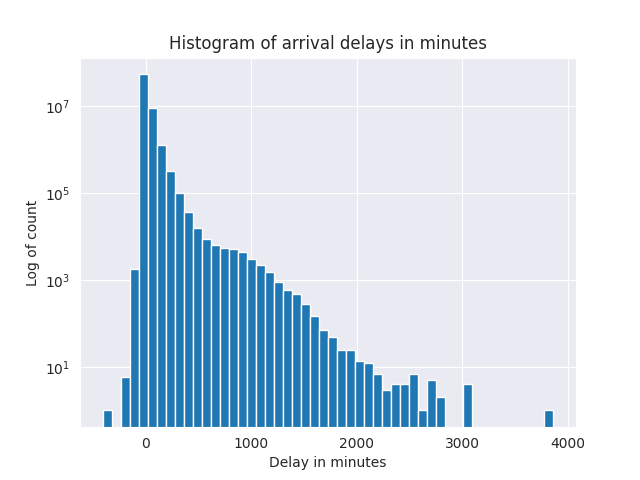

In [7]:
# Plot histogram of departure delays.
fig, ax = plt.subplots()
ax.bar(
    x=bin_centers, height=bin_vals, width=bin_width
)
ax.set_yscale("log")
ax.set_title("Histogram of arrival delays in minutes")
ax.set_xlabel("Delay in minutes")
ax.set_ylabel("Log of count")
%matplot plt

Note that the above is **log-scaled** on the y-axis.

In [8]:
# Convert delay time to a categorical variable and summarize.
# Delayed flights and cancelled flights are not grouped 
# together here, though they may be later on.
categorical_delay_count_pdf = (
    join_df
    .withColumn(
        "delay_status", 
        F.when(F.col("arr_delay") > 0, "Delayed")
        .when(F.col("cancelled") == 1, "Cancelled")
        .otherwise("OnTime")
    )
    .groupby("delay_status").count()
    .toPandas()
    .sort_values("count")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

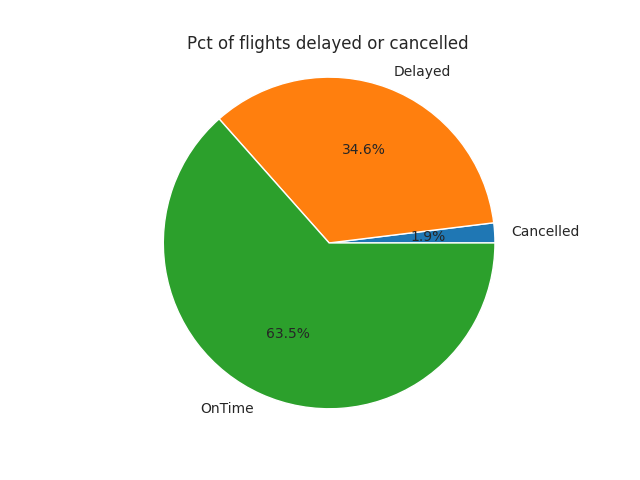

In [9]:
fig, ax = plt.subplots()
ax.pie(
    categorical_delay_count_pdf["count"].values, 
    labels=categorical_delay_count_pdf["delay_status"].values,
    autopct="%1.1f%%"
)
ax.set_title(f"Pct of flights delayed or cancelled")
ax.axis("equal")
%matplot plt

### Airports

In [20]:
# Get the number of inbound and outbound flights
# for each airport.
outbound_airport_count_pdf = (
    join_df
    .groupby("origin").count()
    .toPandas() # Convert to pandas for plotting.
    .rename(columns={
        "count": "NumberOfFlights"
    })
    .sort_values("NumberOfFlights")
)
inbound_airport_count_pdf = (
    join_df
    .groupby("dest").count()
    .toPandas() # Convert to pandas for plotting.
    .rename(columns={ 
        "count": "NumberOfFlights"
    })
    .sort_values("NumberOfFlights")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

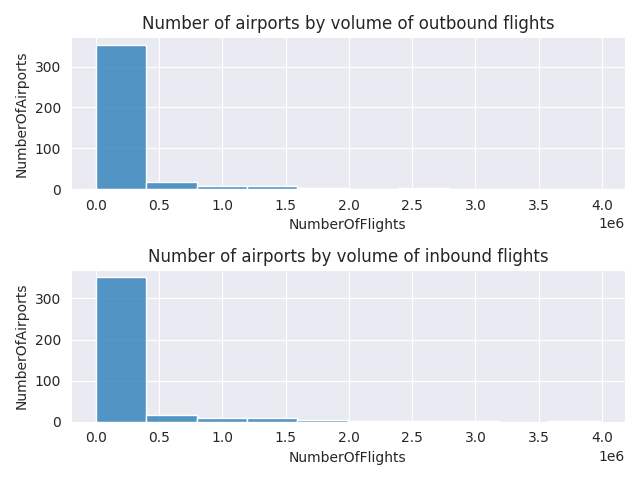

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
sns.histplot(data=outbound_airport_count_pdf, x="NumberOfFlights", bins=10, ax=ax1)
sns.histplot(data=inbound_airport_count_pdf, x="NumberOfFlights", bins=10, ax=ax2)
ax1.set_ylabel("NumberOfAirports")
ax2.set_ylabel("NumberOfAirports")
ax1.set_title("Number of airports by volume of outbound flights")
ax2.set_title("Number of airports by volume of inbound flights")
fig.tight_layout()
%matplot plt

What this shows is that the vast majority of airports have only account for a small amount of traffic.

### Reason for delays <a class="anchor" id="reason-delay"></a>
We now explore the reason that delays occured and if relationships to variables associated with different reasons (e.g. precipitation).

In [59]:
# Dictionary for cancellation codes and their respective descriptions.
# Obtained from: https://www.transtats.bts.gov/Download_Lookup.asp?Y11x72=Y_PNaPRYYNgVba
cancellation_code_dict = {
    "A": "Carrier",
    "B": "Weather",
    "C": "National Air System",
    "D": "Security"
}
delay_col_dict = {
    "carrier_delay": "Carrier",
    "weather_delay": "Weather",
    "nas_delay": "National Air System",
    "security_delay": "Security",
    "late_aircraft_delay": "Late Aircraft"
}

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
# Get the frequencies of different cancellation types.
cancellation_count_pdf = (
    join_df
    .filter(F.col("cancelled")==1)
    .groupby("cancellation_code").count()
    .toPandas()
    .rename(columns={"count": "Count"})
    .sort_values("Count")
)
# Compute columns to display in plot.
cancellation_count_pdf["Description"] = (
    cancellation_count_pdf["cancellation_code"]
    .map(cancellation_code_dict)
)
cancellation_count_pdf["DelayStatus"] = "Cancelled"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# Get the proportional frequences of different delay types.
delay_cols = list(delay_col_dict.keys())
delay_col_sum = sum(F.col(col) for col in delay_cols)
delay_count_pdf = (
    join_df
    .filter(F.col("arr_delay") > 0)
    .select(*[(F.col(col) / delay_col_sum).alias(col) for col in delay_cols])
    .agg( *[F.sum(col).alias(col) for col in delay_cols])
    .toPandas()
    .melt(var_name="delay_col", value_name="count")
    .rename(columns={"count": "Count"})
)
# Compute columns to display in plot.
delay_count_pdf["Description"] = (
    delay_count_pdf["delay_col"]
    .map(delay_col_dict)
)
delay_count_pdf["DelayStatus"] = "Delayed"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
# Concatenate both count dataframes computed above.
delay_cancellation_count_pdf = (
    pd.concat([cancellation_count_pdf, delay_count_pdf])
    .groupby(["DelayStatus", "Description"], as_index=False)
    .sum()
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

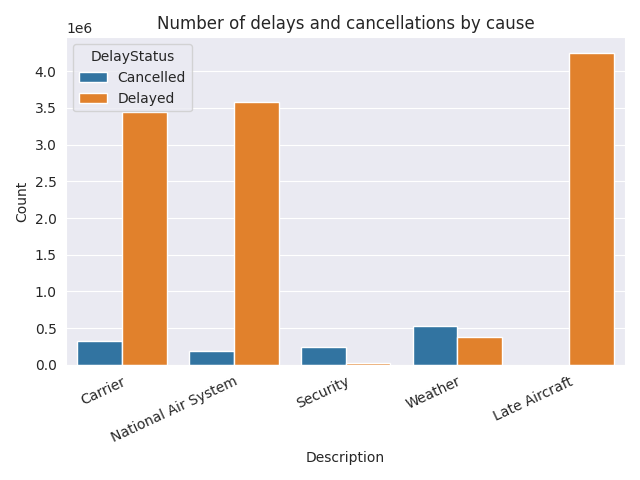

In [74]:
fig, ax = plt.subplots()
sns.barplot(
    data=delay_cancellation_count_pdf,
    x="Description", y="Count", hue="DelayStatus", ax=ax
)
ax.set_title("Number of delays and cancellations by cause")
plt.setp(ax.get_xticklabels(), rotation=25, ha="right", rotation_mode="anchor")
fig.tight_layout()
%matplot plt

From this, we can see that late aircrafts and the national air system account for the majority of the delays.
Because we have no data on the national air system, 
and cannot know ahead of time if there are late aircrafts or security concerns,
we cannot feasibly use these features to predict delay times.
This leaves us with delays by carrier and weather for use in our predictions.

### Carriers

In [64]:
# Get the frequencies of different airlines.
carrier_count_pdf = (
    join_df
    .withColumn(
        "delay_status", 
        F.when(F.col("arr_delay") > 0, "Delayed")
        .when(F.col("cancelled") == 1, "Cancelled")
        .otherwise("OnTime")
    )
    .groupby("delay_status", "op_carrier").count()
    .toPandas() # Convert to pandas for plotting.
    .rename(columns={
        "delay_status": "DelayStatus", 
        "op_carrier": "Carrier", 
        "count": "Count"
    })
    .sort_values("Count")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

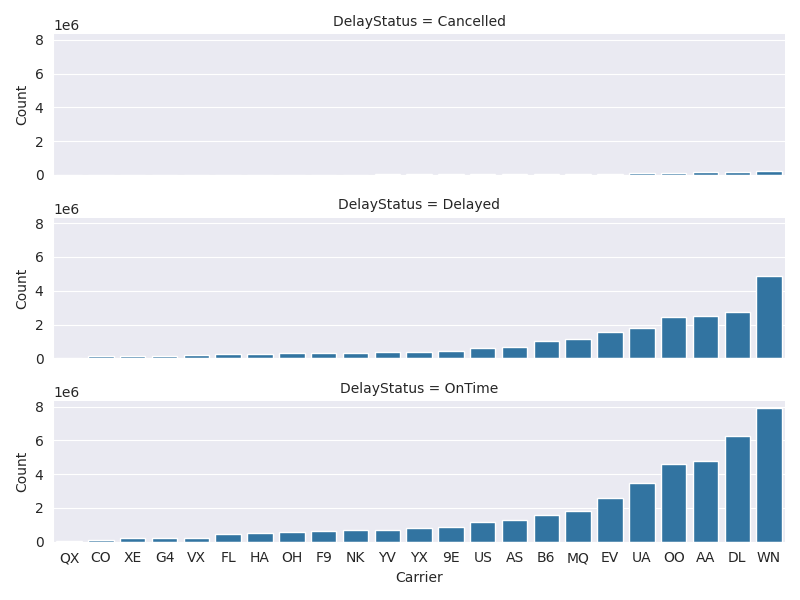

In [65]:
g = sns.FacetGrid(carrier_count_pdf, row="DelayStatus", height=2, aspect=4)
g.map(sns.barplot, "Carrier", "Count")
ax.set_title("Number of flights by carrier")
%matplot plt

In [66]:
# Get percentage of delayed flights by carrier.
carrier_delay_pct_pdf = (
    join_df
    .withColumn(
        "is_delayed", 
        # Combining delayed and cancelled flights here.
        F.when((F.col("arr_delay") > 0) | (F.col("cancelled") == 1), 1)
    )
    .groupby("op_carrier")
    .agg((F.sum("is_delayed") / F.count("op_carrier")).alias("PctDelayed"))
    .toPandas() # Convert to pandas for plotting.
    .rename(columns={"op_carrier": "Carrier"})
    .sort_values("PctDelayed")
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

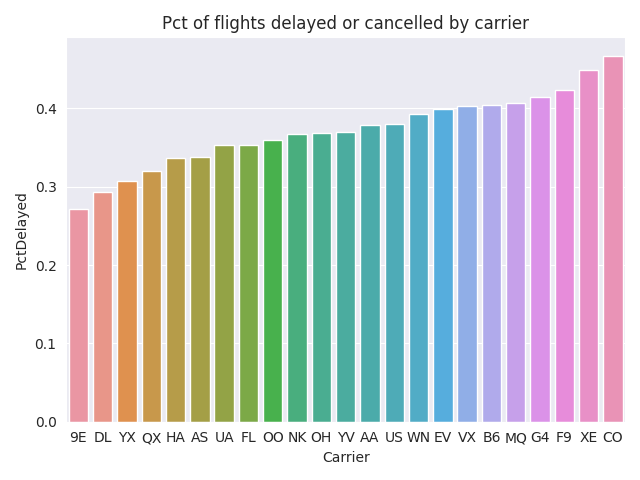

In [75]:
fig, ax = plt.subplots()
sns.barplot(
    data=carrier_delay_pct_pdf,
    x="Carrier", y="PctDelayed", ax=ax,
)
ax.set_title("Pct of flights delayed or cancelled by carrier")
fig.tight_layout()
%matplot plt

### Weather

In [99]:
# Compute correlation between delay and weather statistics.
corr_cols = [
    "arr_delay", 
    "origin_latitude", "origin_longitude",
    "dest_latitude", "dest_longitude",
    "origin_prcp", "origin_snow", "origin_snwd", "origin_tmax", "origin_tmin",
    "dest_prcp", "dest_snow", "dest_snwd", "dest_tmax", "dest_tmin",
]
vec_assembler = ml.feature.VectorAssembler(
    inputCols=corr_cols, 
    outputCol="corr_features", 
    handleInvalid="skip"
)
corr_feature_df = vec_assembler.transform(
    join_df
    .select(*corr_cols)
    .na.fill(0.0, subset=[col for col in corr_cols if "tm" not in col])
)
corr_matrix = ml.stat.Correlation.corr(corr_feature_df, column="corr_features")
corr_ndarray = corr_matrix.collect()[0][0].toArray()
corr_pdf = pd.DataFrame(corr_ndarray, index=corr_cols, columns=corr_cols)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

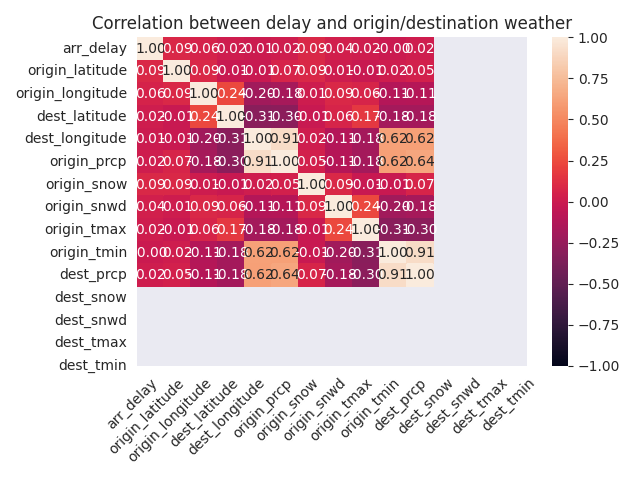

In [100]:
fig, ax = plt.subplots()
sns.heatmap(
    corr_df, 
    vmin=-1.0, vmax=1.0, annot=True, fmt=".2f",
    xticklabels=corr_cols, yticklabels=corr_cols, ax=ax
)
ax.set_title("Correlation between delay and origin/destination weather")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()
%matplot plt

This, in combination with the results from [reason for delays](#reason-delay), 
suggests that weather is not a strong predictor of delay times.